In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from scipy.stats import kruskal
from sklearn.model_selection import cross_validate

Je fixe le hasard grâce au paramètre random_state que je fixe à 42.

In [4]:
random_state = 42

In [5]:
df = pd.read_csv('dataset.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df[df['age'] == 18]

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
22,18,male,34.100,0,no,southeast,1137.01100
31,18,female,26.315,0,no,northeast,2198.18985
46,18,female,38.665,2,no,northeast,3393.35635
50,18,female,35.625,0,no,northeast,2211.13075
...,...,...,...,...,...,...,...
1296,18,male,26.125,0,no,northeast,1708.92575
1315,18,male,28.310,1,no,northeast,11272.33139
1317,18,male,53.130,0,no,southeast,1163.46270
1334,18,female,31.920,0,no,northeast,2205.98080


In [7]:
df.sort_values(['age', 'bmi'])

,age,sex,bmi,children,smoker,region,charges
172,18,male,15.960,0,no,northeast,1694.79640
250,18,male,17.290,2,yes,northeast,12829.45510
359,18,female,20.790,0,no,southeast,1607.51010
1212,18,male,21.470,0,no,northeast,1702.45530
1033,18,male,21.565,0,yes,northeast,13747.87235
...,...,...,...,...,...,...,...
603,64,female,39.050,3,no,southeast,16085.12750
418,64,male,39.160,1,no,southeast,14418.28040
199,64,female,39.330,0,no,northeast,14901.51670
768,64,female,39.700,0,no,southwest,14319.03100


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Je vais commencer par étudier la corrélation entre les variables numériques et la cible

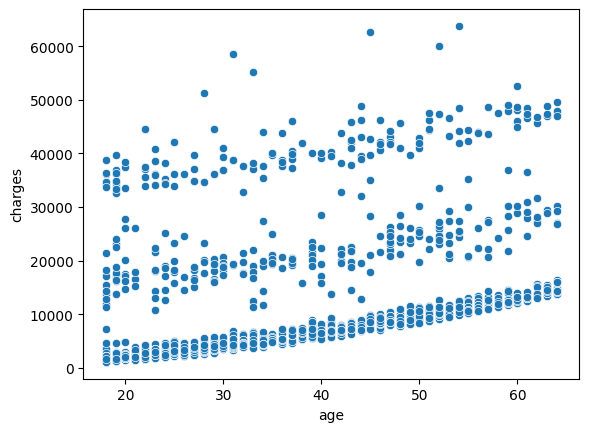

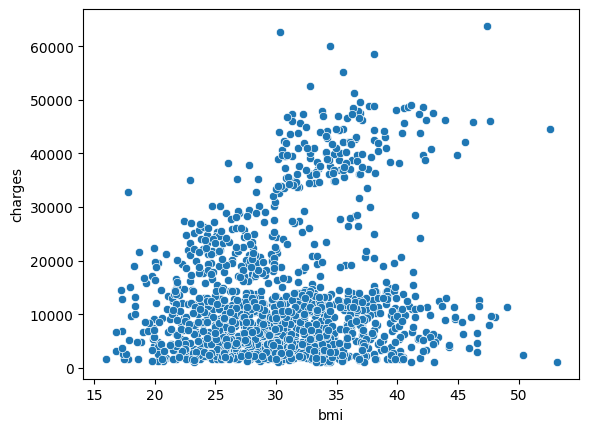

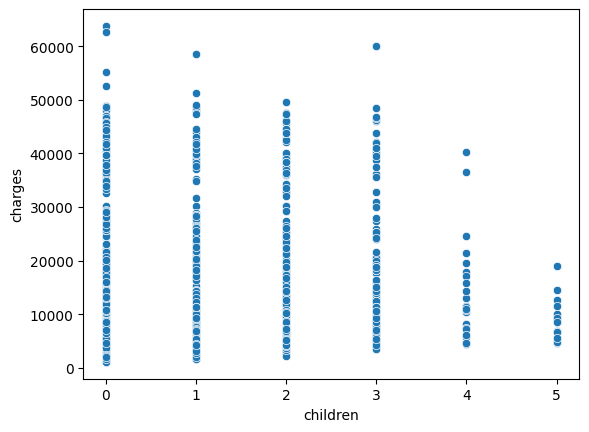

In [9]:
num_col = ['age', 'bmi', 'children']

for col in num_col :
    sns.scatterplot(data=df, x=col, y='charges')
    plt.show()

Je refais les mêmes graphiques en affichant les fumeurs car instinctivement, je pense que ça sera une variable importante.

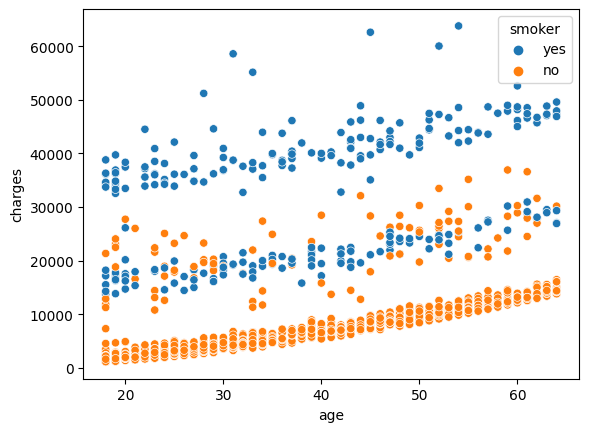

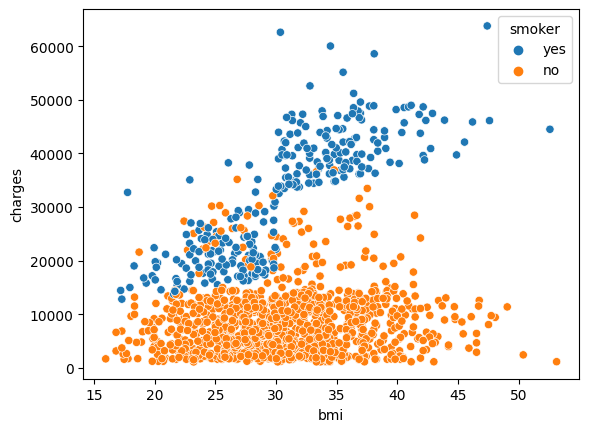

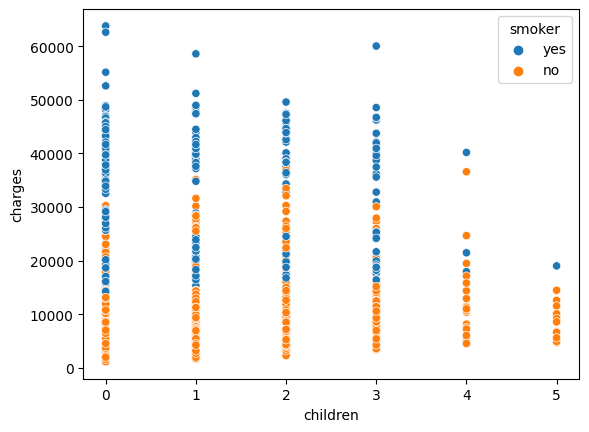

In [10]:
num_col = ['age', 'bmi', 'children']

for col in num_col :
    sns.scatterplot(data=df, x=col, y='charges', hue='smoker')
    plt.show()

En réfléchissant, je me dis que les bmi supérieurs à 30 ou inférieurs à 18 seront des indicateurs d'une mauvaise santé. Je décide donc d'encoder ses variables en catégorie pour plus facilement les gérer avec une régression linéaire. 

In [11]:
df.loc[df['bmi'] < 18.5 , 'grade'] = 'underweight'
df.loc[df['bmi'].between(18.5, 25, 'both'), 'grade'] = 'good'
df.loc[df['bmi'].between(25, 30, 'right'), 'grade'] = 'overweight'
df.loc[df['bmi'] > 30 , 'grade'] = 'obesity'
df.drop('bmi',axis=1, inplace=True)

In [12]:
df['grade'].value_counts()

obesity        705
overweight     386
good           227
underweight     20
Name: grade, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
 6   grade     1338 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 73.3+ KB


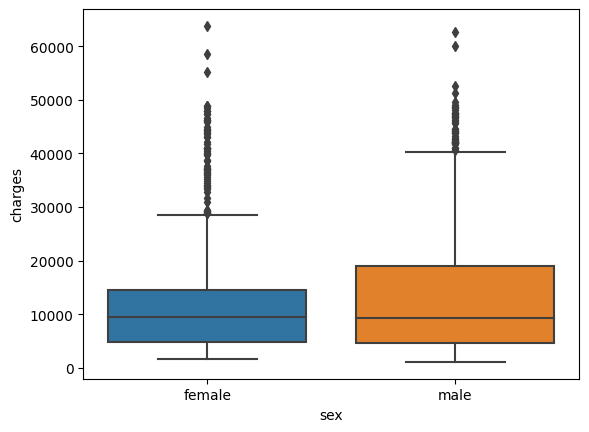

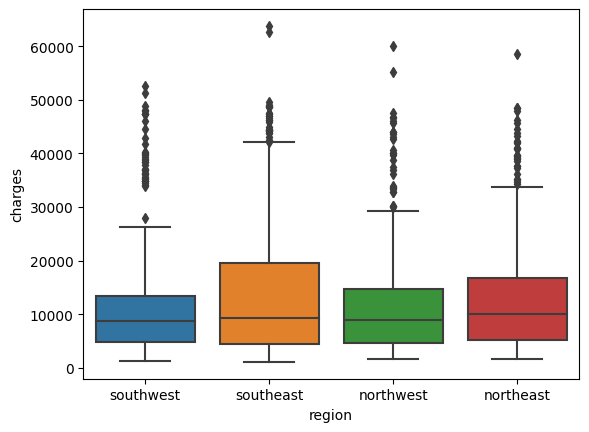

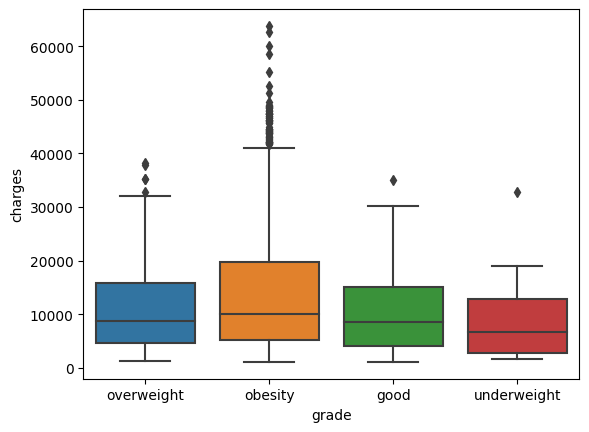

In [14]:
cat_col = ['sex', 'region', 'grade']

for cat in cat_col :
    sns.boxplot(data=df, x=cat, y='charges')
    plt.show()

## Est-ce que la région a un impact sur les charges ?

In [15]:
# Les exemples sont équitablement distribués parmi toutes les régions
df.value_counts('region')

region
southeast    364
northwest    325
southwest    325
northeast    324
dtype: int64

<AxesSubplot: xlabel='region', ylabel='charges'>

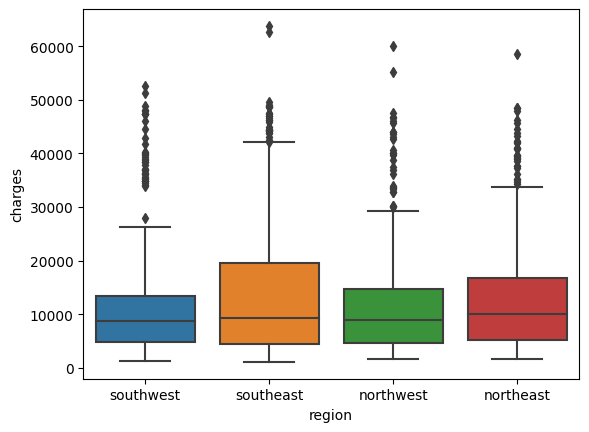

In [16]:
sns.boxplot(data=df, x='region', y='charges')

In [17]:
list_df = [df[df['region'] == region]['charges'] for region in df.region.unique()]

In [18]:
kruskal(*list_df)

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

La p-value n'est pas inférieur au seuil alpha de 0.05, je ne peux pas rejetter l'hypothèse nulle. Les médianes des groupes ne sont pas différentes.

In [19]:
import scikit_posthocs as sp
sp.posthoc_dunn(list_df, p_adjust = 'bonferroni')

,1,2,3,4
1,1.000000,1.0,1.00000,0.279062
2,1.000000,1.0,1.00000,1.000000
3,1.000000,1.0,1.00000,0.763630
4,0.279062,1.0,0.76363,1.000000


In [20]:
list_df[0]

0       16884.92400
12       1826.84300
15       1837.23700
18      10602.38500
19      36837.46700
           ...     
1316     1731.67700
1329    10325.20600
1331    10795.93733
1332    11411.68500
1336     2007.94500
Name: charges, Length: 325, dtype: float64

## Modélisation

<AxesSubplot: xlabel='charges', ylabel='Count'>

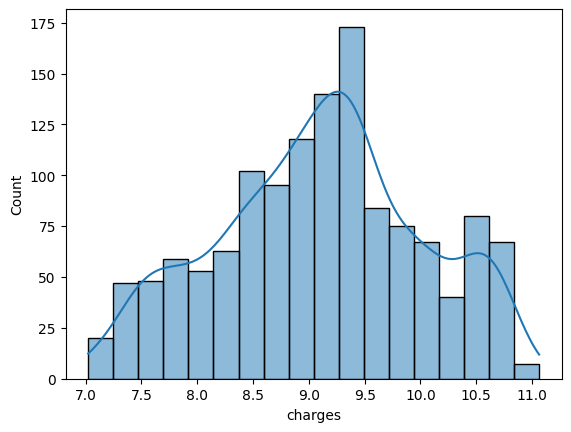

In [21]:
test = np.log(df['charges'])

sns.histplot(x=test, kde=True)

In [22]:
df.drop_duplicates(inplace=True)
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
dummy = DummyRegressor()
X_train.head()
dummy.fit(X_train, y_train)


DummyRegressor()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   children  1337 non-null   int64  
 3   smoker    1337 non-null   object 
 4   region    1337 non-null   object 
 5   charges   1337 non-null   float64
 6   grade     1337 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 83.6+ KB


In [24]:
X.grade

0       overweight
1          obesity
2          obesity
3             good
4       overweight
           ...    
1333       obesity
1334       obesity
1335       obesity
1336    overweight
1337    overweight
Name: grade, Length: 1337, dtype: object

## Préparation des données

In [25]:
onehot = OneHotEncoder(drop="if_binary")
std = StandardScaler()
num_pipe = make_pipeline(StandardScaler(),)
onehot_col_std = make_column_transformer(
    (onehot, ['sex', 'region', 'smoker', 'grade']),
    (num_pipe, ['age',  'children'])
    )
preprocessing_poly_std = make_pipeline(onehot_col_std, PolynomialFeatures())

In [26]:
lr = LinearRegression()
# lr_pipe = make_pipeline(preprocessing_poly, lr)
lr_pipe_std = make_pipeline(preprocessing_poly_std, lr)
lr_pipe_std.fit(X_train, y_train)
cross_validate(lr_pipe_std, X_train, y_train, cv=5)['test_score'].mean()

0.8456899511551885

In [27]:
lr_pipe_std[-1].coef_

array([ 9.04937230e+12, -8.12590433e+15, -7.74353396e+16,  2.53191984e+16,
       -1.95717007e+15,  1.08519486e+17,  1.29463117e+16, -7.16313749e+16,
       -1.08116853e+17, -2.61694426e+16, -3.77369498e+16, -1.86619198e+15,
        2.50016684e+17, -1.04917686e+16,  5.50795054e+16,  5.50795054e+16,
        5.50795054e+16,  5.50795054e+16, -1.03481178e+02, -3.64618324e+16,
       -3.64618324e+16, -3.64618324e+16, -3.64618324e+16, -1.37415838e+01,
       -1.89488300e+01,  1.16533174e+17, -2.18525088e+16,  5.62476969e+15,
        2.92569771e+16, -2.27143647e+16,  1.92198179e+16,  1.85744898e+16,
        5.05698963e+15, -1.44232367e+14,  6.75500911e+16, -1.25253294e+17,
        7.46389043e+14, -9.06867921e+14,  1.89194141e+16, -2.27143647e+16,
        3.22520650e+16,  3.16067369e+16,  1.80892367e+16,  1.28880147e+16,
        6.75500911e+16, -1.25253294e+17,  7.83070853e+16,  1.52975869e+15,
       -2.27143647e+16, -1.80322628e+16, -1.86775909e+16, -3.21950911e+16,
        9.60000000e+01,  

In [28]:
el = ElasticNet(random_state=42, tol=0.0001, max_iter=10000)
# el = ElasticNet()
el_pipe_poly = make_pipeline(preprocessing_poly_std, el)
el_pipe_poly.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'),
                                                                   ['sex',
                                                                    'region',
                                                                    'smoker',
                                                                    'grade']),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'children'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())])),
                ('elasticnet', ElasticNet(max_iter=10000, random_state=42))])

In [29]:
el_pipe_poly.score(X_train, y_train)

0.6177930295846359

In [30]:
el_pipe_poly.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('columntransformer',
                    ColumnTransformer(transformers=[('onehotencoder',
                                                     OneHotEncoder(drop='if_binary'),
                                                     ['sex', 'region', 'smoker',
                                                      'grade']),
                                                    ('pipeline',
                                                     Pipeline(steps=[('standardscaler',
                                                                      StandardScaler())]),
                                                     ['age', 'children'])])),
                   ('polynomialfeatures', PolynomialFeatures())])),
  ('elasticnet', ElasticNet(max_iter=10000, random_state=42))],
 'verbose': False,
 'pipeline': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('onehotencoder',
                           

In [31]:
alpha_range = np.linspace(0.0001, 100, 1500)
l1_ratio_range = np.linspace(0, 1, 500)
param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[1]}
elastic_grid = RandomizedSearchCV(el_pipe_poly, param_distributions, n_iter=500, cv=5, random_state=random_state, verbose=0)

In [32]:
elastic_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('onehotencoder',
                                                                                                OneHotEncoder(drop='if_binary'),
                                                                                                ['sex',
                                                                                                 'region',
                                                                                                 'smoker',
                                                                                                 'grade']),
                                                                                               ('pipeline',
                                                                                                Pipeline(steps=[('standardscaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['age',
                                                                                                 'children'])])),
                                                              ('polynomialfeatures',
                                                               PolynomialFeatures())])),
                                             ('elasticnet',
                                              ElasticNet(max_iter=10000,
                                                         random_state=42))]),
                   n_iter=500,
                   param_distributions={'elasticnet__alpha': array([1.00000000e-04, 6.68110740e-02, 1.33522148e-01, ...,
       9.98665779e+01, 9.99332889e+01, 1.00000000e+02]),
                                        'elasticnet__l1_ratio': [1]},
                   random_state=42)

In [33]:
elastic_grid.best_score_

0.8515543505572787

In [34]:
elastic_grid.best_params_

{'elasticnet__l1_ratio': 1, 'elasticnet__alpha': 55.90398005336891}

In [35]:
alpha_range = np.linspace(50,60,100)

param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[1]}
elastic_grid_opti = GridSearchCV(el_pipe_poly, param_distributions, cv=5, verbose=0)

In [36]:
elastic_grid_opti.fit(X_train, y_train)
elastic_grid_opti.best_score_

0.8515552665023328

In [37]:
elastic_grid_opti.best_params_

{'elasticnet__alpha': 55.55555555555556, 'elasticnet__l1_ratio': 1}

In [38]:
elastic_grid_opti.score(X_test, y_test)

0.9203503999762638

# Analyse des résultats 

In [39]:
residual = np.abs(elastic_grid_opti.predict(X_train) - y_train)

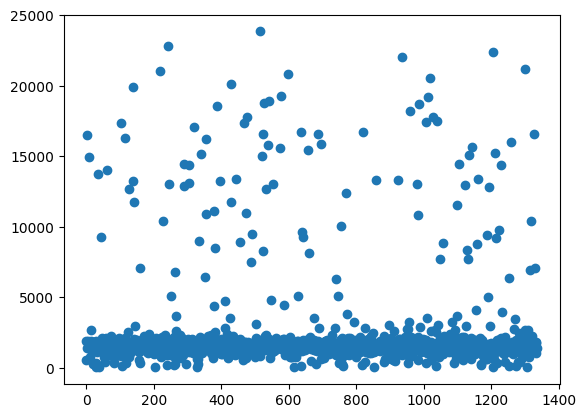

In [40]:
plt.scatter(X_train.index, residual)

In [41]:
pipe_sm = make_column_transformer((OneHotEncoder(drop='first'), ['sex', 'region', 'smoker', 'grade']), (std, ['age',  'children']))

In [42]:
preprocessing_poly_std

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'region', 'smoker',
                                                   'grade']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures())])

In [43]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

n = X_train.shape[0]
p = X_train.shape[1]

X_transformed = preprocessing_poly_std.fit_transform(X_train)
col_name = preprocessing_poly_std.get_feature_names_out()

X_transformed = pd.DataFrame(data=X_transformed, columns=col_name, index=y_train.index)

X_s = sm.add_constant(X_transformed)
model = sm.OLS(y_train, X_s)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     135.4
Date:                Fri, 27 Jan 2023   Prob (F-statistic):               0.00
Time:                        09:57:45   Log-Likelihood:                -11168.
No. Observations:                1136   AIC:                         2.244e+04
Df Residuals:                    1085   BIC:                         2.270e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
1                                                                 1.614e+14   5.27e+15      0.031      0.976   -1.02e+16    1.05e+16
onehotencoder__sex_male                                          -5.831e+12    1.9e+14     -0.031      0.976   -3.79e+14    3.67e+14
onehotencoder__region_northeast                                   -8.14e+14   2.66e+16     -0.031      0.976   -5.29e+16    5.13e+16
onehotencoder__region_northwest                                  -3.741e+14   1.22e+16     -0.031      0.976   -2.43e+16    2.36e+16
onehotencoder__region_southeast                                  -1.102e+14    3.6e+15     -0.031      0.976   -7.17e+15    6.95e+15
onehotencoder__region_southwest                                  -1.155e+14   3.77e+15     -0.031      0.976   -7.51e+15    7.28e+15
onehotencoder__smoker_yes                                        -2.264e+13   7.39e+14     -0.031      0.976   -1.47e+15    1.43e+15
onehotencoder__grade_good                                        -9.727e+12   3.17e+14     -0.031      0.976   -6.33e+14    6.13e+14
onehotencoder__grade_obesity                                      5.327e+13   1.74e+15      0.031      0.976   -3.36e+15    3.46e+15
onehotencoder__grade_overweight                                   8.017e+13   2.62e+15      0.031      0.976   -5.05e+15    5.21e+15
onehotencoder__grade_underweight                                  6.987e+13   2.28e+15      0.031      0.976    -4.4e+15    4.54e+15
pipeline__age                                                    -1.093e+13   3.57e+14     -0.031      0.976   -7.11e+14    6.89e+14
pipeline__children                                                1.827e+13   5.96e+14      0.031      0.976   -1.15e+15    1.19e+15
onehotencoder__sex_male^2                                         -1.44e+13    4.7e+14     -0.031      0.976   -9.37e+14    9.08e+14
onehotencoder__sex_male onehotencoder__region_northeast           3.157e+13   1.03e+15      0.031      0.976   -1.99e+15    2.05e+15
onehotencoder__sex_male onehotencoder__region_northwest           3.157e+13   1.03e+15      0.031      0.976   -1.99e+15    2.05e+15
onehotencoder__sex_male onehotencoder__region_southeast           3.157e+13   1.03e+15      0.031      0.976   -1.99e+15    2.05e+15
onehotencoder__sex_male onehotencoder__region_southwest           3.157e+13   1.03e+15      0.031      0.976   -1.99e+15    2.05e+15
onehotencoder__sex_male onehotencoder__smoker_yes                   61.0719    713.245      0.086      0.932   -1338.423    1460.567
onehotencoder__sex_male onehotencoder__grade_good                -1.134e+13    3.7e+14     -0.031      0.976   -7.37e+14    7.14e+14
onehotencoder__sex_male 

In [44]:
influence = results.get_influence().cooks_distance[0]

seuil_dcook = 4/(n)

In [45]:
results.get_influence().summary_frame().cooks_d.isna().sum()

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:778: RuntimeWarning: invalid value encountered in true_divide
  dfbetas /= np.sqrt(np.diag(self.results.normalized_cov_params))


0

In [46]:
analyses = X_train.copy()

In [47]:
analyses['cook_distance'] = influence

In [48]:
analyses['cook_distance'].isna().sum()

0

In [49]:
analyses

,age,sex,children,smoker,region,grade,cook_distance
1095,18,female,4,no,northeast,obesity,0.001238
94,64,female,2,yes,southwest,obesity,0.000168
349,19,male,0,no,northwest,overweight,0.000009
410,19,male,0,no,northwest,underweight,0.000651
982,31,male,3,yes,southwest,overweight,0.000075
...,...,...,...,...,...,...,...
675,45,male,0,no,northwest,good,0.000021
753,58,female,0,no,southeast,good,0.000297
319,32,male,1,no,northeast,obesity,0.000053
935,59,female,0,no,southwest,overweight,0.000069


In [50]:
seuil_dcook

0.0035211267605633804

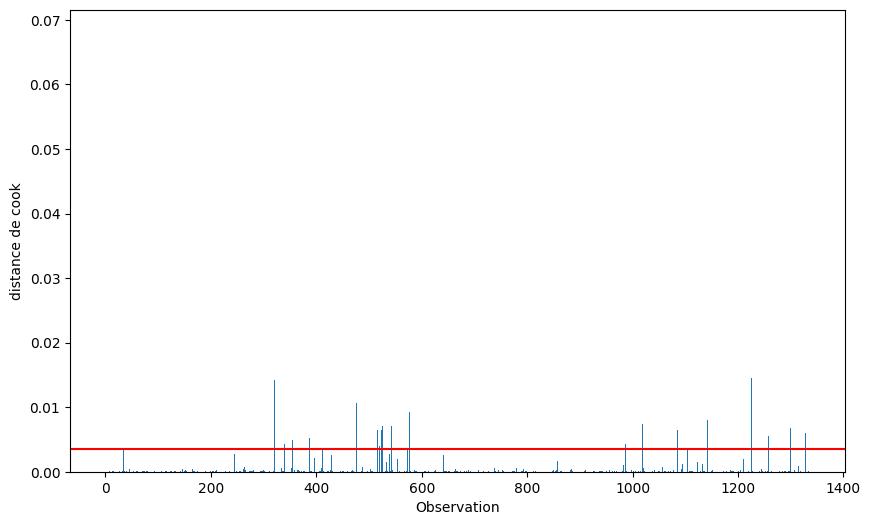

In [51]:
plt.figure(figsize=(10,6))
plt.bar(analyses.index, analyses['cook_distance'])
plt.xlabel('Observation')
plt.ylabel('distance de cook')
plt.axhline(seuil_dcook, color='red')
plt.show()

In [52]:
X_train_cook = X_train[~(analyses['cook_distance'] > seuil_dcook)]
y_train_cook = y_train[~(analyses['cook_distance'] > seuil_dcook)]

In [53]:
102 in (analyses['cook_distance'] > seuil_dcook).index

True

In [54]:
102 in y_train_cook.index

False

In [55]:
to_inspect = X_train[(analyses['cook_distance'] > seuil_dcook)].copy()
to_inspect['target'] = y_train[(analyses['cook_distance'] > seuil_dcook)]
to_inspect

,age,sex,children,smoker,region,grade,target
468,28,female,1,no,northeast,good,23288.92840
599,52,female,2,no,northwest,obesity,33471.97189
1258,55,male,3,no,northwest,obesity,30063.58055
526,19,female,2,no,northwest,obesity,24059.68019
770,61,male,3,no,southwest,obesity,27941.28758
34,28,male,1,yes,southwest,obesity,51194.55914
1012,61,female,4,no,southeast,obesity,36580.28216
524,42,male,1,yes,southeast,overweight,38245.59327
987,45,female,1,no,northwest,overweight,28340.18885
1206,59,female,2,no,southwest,obesity,36910.60803


In [56]:
(analyses['cook_distance'] > seuil_dcook).sum()

48

In [57]:
elastic_grid_opti.fit(X_train_cook, y_train_cook)
elastic_grid_opti.best_score_

0.9338121087562519

In [58]:
alpha_range = np.linspace(0.001, 100, 500)
l1_ratio_range = np.linspace(0, 1, 500)
param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[1]}
elastic_grid = RandomizedSearchCV(el_pipe_poly, param_distributions, n_iter=300, cv=5, random_state=random_state, verbose=0)
elastic_grid.fit(X_train_cook, y_train_cook)
elastic_grid.best_score_

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e+09, tolerance: 1.149e+07
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+09, tolerance: 1.132e+07
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

0.9349268243912758

In [59]:
elastic_grid.best_params_

{'elasticnet__l1_ratio': 1, 'elasticnet__alpha': 15.632106212424848}

In [60]:
alpha_range = np.linspace(40,50,100)

param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[1], 'pipeline__polynomialfeatures__degree': [2]}
elastic_grid_opti = GridSearchCV(el_pipe_poly, param_distributions, cv=5, verbose=0)
elastic_grid_opti.fit(X_train_cook, y_train_cook)
print(elastic_grid_opti.best_params_)
print(elastic_grid_opti.best_score_)
print(elastic_grid_opti.score(X_test, y_test))

{'elasticnet__alpha': 40.0, 'elasticnet__l1_ratio': 1, 'pipeline__polynomialfeatures__degree': 2}
0.9342721616643089
0.9235388495953045


In [61]:
el_pipe_poly.set_params(**elastic_grid_opti.best_params_)
el_pipe_poly.fit(X_train_cook, y_train_cook)
el_pipe_poly.score(X_test, y_test)

0.9235388495953045

In [62]:
import pickle
pickle.dump(el_pipe_poly, open('model.pkl', 'wb'))

In [67]:
X_train_cook.iloc[0]

age                18
sex            female
children            4
smoker             no
region      northeast
grade         obesity
Name: 1095, dtype: object

In [70]:
cols = list(X_train_cook.columns)
value = [18, 'female', 4, 'no', 'northeast', 'obesity'] 
to_predict = dict(zip(cols, value))
to_predict = pd.DataFrame(to_predict, index=[0])
el_pipe_poly.predict(to_predict)

In [78]:
cols

['age', 'sex', 'children', 'smoker', 'region', 'grade']

array([5889.0451691])

In [64]:
el_pipe_poly.predict()

TypeError: Pipeline.predict() missing 1 required positional argument: 'X'

In [ ]:
col_name = preprocessing_poly_std.get_feature_names_out()

pd.DataFrame(data=el_pipe_poly[-1].coef_, columns=['coefs'], index=col_name)

,coefs
1,0.000000
onehotencoder__sex_male,-237.392682
onehotencoder__region_northeast,25.481719
onehotencoder__region_northwest,-0.000000
onehotencoder__region_southeast,0.000000
...,...
onehotencoder__grade_underweight pipeline__age,0.000000
onehotencoder__grade_underweight pipeline__children,-0.000000
pipeline__age^2,482.690691
pipeline__age pipeline__children,-0.000000


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

n = X_train.shape[0]
p = X_train.shape[1]

X_transformed = preprocessing_poly_std.fit_transform(X_train)
col_name = preprocessing_poly_std.get_feature_names_out()

X_transformed = pd.DataFrame(data=X_transformed, columns=col_name, index=y_train.index)

X_s = sm.add_constant(X_transformed)
model = sm.OLS(y_train, X_s)
results = model.fit_regularized(method='elastic_net', alpha=40.0)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = results.model.exog
data =[variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [ ]:
len(data)

91

In [ ]:
index = list(el_pipe_poly[:-1].get_feature_names_out())

vif_data = pd.DataFrame(data=data, index=index, columns=['vif'])

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
vif_data.sort_index()

,vif
1,0.000000e+00
onehotencoder__grade_good,2.075830e+07
onehotencoder__grade_good onehotencoder__grade_obesity,NaN
onehotencoder__grade_good onehotencoder__grade_overweight,NaN
onehotencoder__grade_good onehotencoder__grade_underweight,NaN
onehotencoder__grade_good pipeline__age,4.063580e+07
onehotencoder__grade_good pipeline__children,5.289444e+07
onehotencoder__grade_good^2,8.439372e+07
onehotencoder__grade_obesity,7.846761e+06
onehotencoder__grade_obesity onehotencoder__grade_overweight,NaN


In [ ]:
mask = [np.array([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]) > 10]
mask = pd.Series(*mask)

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [ ]:
name = pd.Series(results.model.exog_names.insert(0, 'constant'))



/var/folders/2l/lrfmhv4549d6_vj6k4zkk90c0000gn/T/ipykernel_22840/3003933989.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  name = pd.Series(results.model.exog_names.insert(0, 'constant'))


In [ ]:
name.shape

(0,)

In [ ]:
name[mask]

Series([], dtype: float64)

In [ ]:
name

Series([], dtype: float64)